In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import statsmodels.api as sm

portfolios_df = pd.read_csv('problem3.csv')
daily_prices = pd.read_csv('DailyPrices.csv')

In [122]:
# Constants
S = 170.15
r = 5.25 / 100
q = 0.57 / 100
curr_date = np.datetime64('2023-10-30')

In [123]:
# Black-Scholes Model
def black_scholes(option_type, S, K, r, q, sigma, T):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

# IV
def implied_volatility(option_type, S, K, T, option_price, r, q):
    func = lambda sigma: black_scholes(option_type, S, K, r, q, sigma, T) - option_price
    try:
        implied_vol = brentq(func, 0.001, 3.0)
    except (ValueError, TypeError):
        implied_vol = np.nan
    return implied_vol

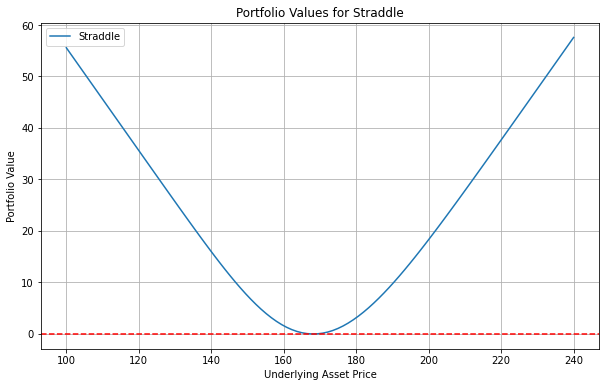

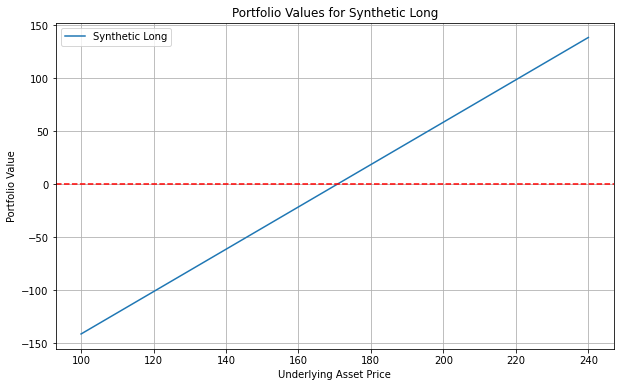

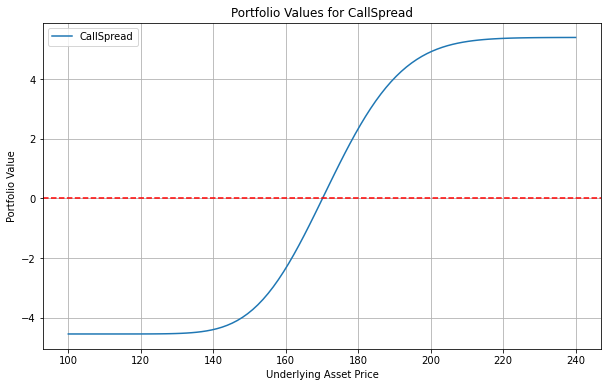

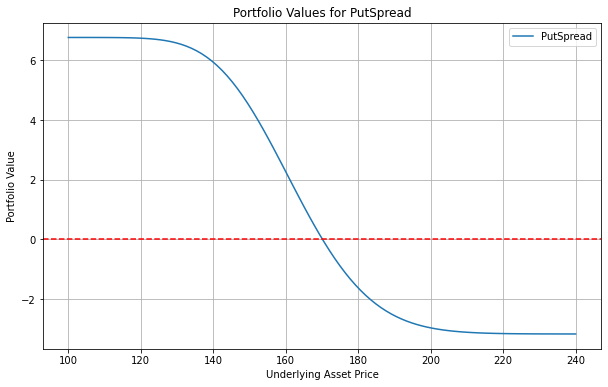

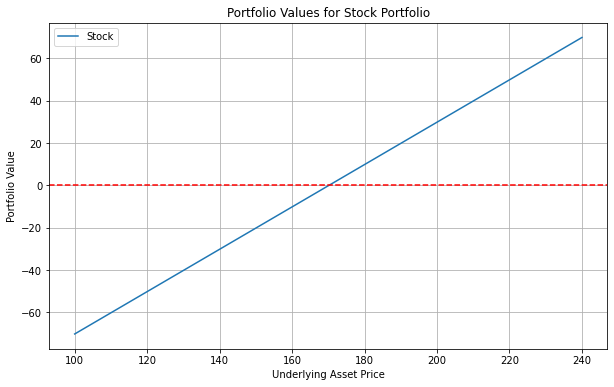

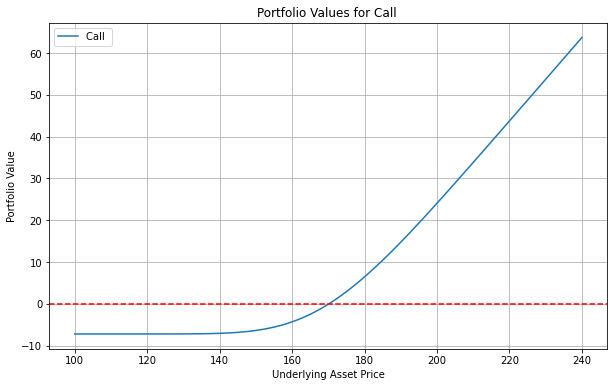

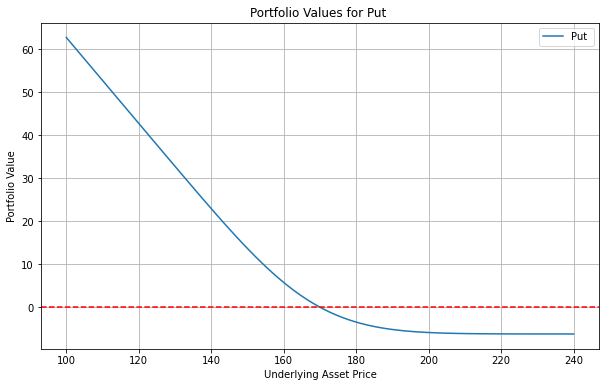

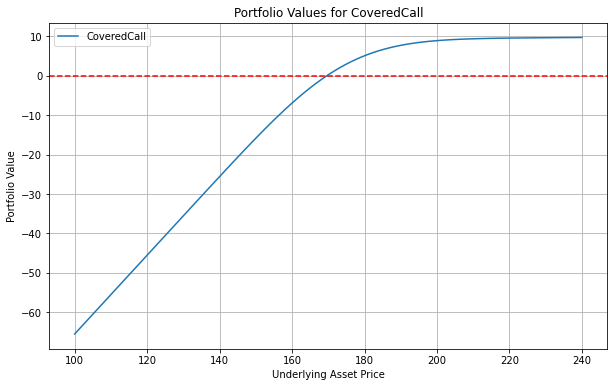

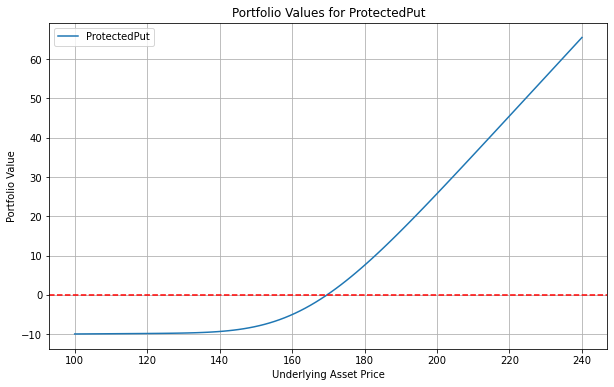

In [127]:
def time_to_expiration(exp_date):
    current_date = pd.to_datetime('2023-10-30')
    T = (pd.to_datetime(exp_date) - current_date).days / 365
    return T

def plot_portfolio(title, values, label):
    plt.figure(figsize=(10, 6))
    plt.plot(underlying_prices, values, label=label)
    plt.title(f"Portfolio Values for {title}")
    plt.xlabel("Underlying Asset Price")
    plt.ylabel("Portfolio Value")
    plt.axhline(0, color='red', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.show()

underlying_prices = np.linspace(100, 240, 100)

portfolios_df['implied_vol'] = portfolios_df.apply(
    lambda row: implied_volatility(
        row['OptionType'].lower(), current_price, row['Strike'], 
        time_to_expiration(row['ExpirationDate']), row['CurrentPrice'], 
        risk_free_rate, dividend_rate
    ) if row['Type'] == 'Option' else np.nan,
    axis=1
)

option_portfolios_df = portfolios_df.dropna(subset=['ExpirationDate']).copy()
stock_portfolios_df = portfolios_df[portfolios_df['Type'] == 'Stock']

all_portfolio_values = {}

for portfolio in portfolios_df['Portfolio'].unique():
    portfolio_values = []

    if portfolio == 'Stock':
        # Stock only portfolio
        holding = stock_portfolios_df[stock_portfolios_df['Portfolio'] == 'Stock']['Holding'].values[0]
        payoff = holding * underlying_prices - current_price
        plot_portfolio('Stock Portfolio', payoff, 'Stock')
        all_portfolio_values['Stock'] = payoff

    elif portfolio == 'SynLong':
        # Synthetic Long (long call and short put at the same strike)
        synlong_call_price = option_portfolios_df[(option_portfolios_df['Portfolio'] == 'SynLong') & (option_portfolios_df['OptionType'] == 'Call')]['CurrentPrice'].values[0]
        synlong_put_price = option_portfolios_df[(option_portfolios_df['Portfolio'] == 'SynLong') & (option_portfolios_df['OptionType'] == 'Put')]['CurrentPrice'].values[0]
        
        for S in underlying_prices:
            total_payoff = 2 * (S - current_price) - (synlong_call_price - synlong_put_price)
            portfolio_values.append(total_payoff)

        plot_portfolio('Synthetic Long', portfolio_values, 'Synthetic Long')
        all_portfolio_values['SynLong'] = portfolio_values

    else:
        # Options without stock
        portfolio_options = option_portfolios_df[option_portfolios_df['Portfolio'] == portfolio]
        
        if portfolio_options.empty:
            print(f"No data found for portfolio type: {portfolio}")
            continue
        
        initial_cost = sum(row['Holding'] * row['CurrentPrice'] for _, row in portfolio_options.iterrows())
        
        for S in underlying_prices:
            value = 0
            for _, row in portfolio_options.iterrows():
                T = time_to_expiration(row['ExpirationDate'])
                implied_vol = row['implied_vol']
                if pd.isna(implied_vol):
                    print(f"Skipping option with NaN implied volatility for {portfolio}")
                    continue
                option_price = black_scholes(
                    row['OptionType'].lower(), S, row['Strike'], risk_free_rate, dividend_rate,
                    implied_vol, T
                )
                value += row['Holding'] * option_price

            if portfolio == 'CoveredCall':
                # Covered Call: long stock + short call
                df1 = portfolio_options[portfolio_options['Portfolio'] == 'CoveredCall']
                implied_vol = df1['implied_vol'].values[0]
                T = time_to_expiration(df1['ExpirationDate'].values[0])
                option_price = black_scholes(
                    'call', S, df1['Strike'].values[0], risk_free_rate, risk_free_rate - dividend_rate,
                    implied_vol, T
                )
                payoff = df1['CurrentPrice'].values[0] - option_price + S - current_price
                portfolio_values.append(payoff)

            elif portfolio == 'ProtectedPut':
                # Protected Put: long stock + long put
                df1 = portfolio_options[portfolio_options['Portfolio'] == 'ProtectedPut']
                implied_vol = df1['implied_vol'].values[0]
                T = time_to_expiration(df1['ExpirationDate'].values[0])
                option_price = black_scholes(
                    'put', S, df1['Strike'].values[0], risk_free_rate, risk_free_rate - dividend_rate,
                    implied_vol, T
                )
                payoff = option_price - df1['CurrentPrice'].values[0] + df1['Holding'].values[0] * S - current_price
                portfolio_values.append(payoff)

            else:
                portfolio_values.append(value - initial_cost)

        if len(portfolio_values) > 0:
            plot_portfolio(portfolio, portfolio_values, portfolio)
            all_portfolio_values[portfolio] = portfolio_values


In [139]:
aapl_log_returns = np.log(daily_prices['AAPL'] / daily_prices['AAPL'].shift(1)).dropna()
aapl_log_returns_demeaned = aapl_log_returns - aapl_log_returns.mean()

In [145]:
# Fit AR(1) Model
ar1_model = sm.tsa.arima.ARIMA(aapl_log_returns_demeaned, order=(1, 0, 0))
ar1_fit = ar1_model.fit()

con = ar1_fit.params[0]
beta = ar1_fit.params[1]
sigma = np.sqrt(ar1_fit.params[2])

# Simulate AAPL returns
def ar1_sim(r, ndays, p0, nsim=10000, seed=20):
    np.random.seed(seed)
    rsim = np.zeros((nsim, ndays))
    for i in range(nsim):
        rsim[i, 0] = con + beta * r.iloc[-1] + sigma * np.random.normal()
        for j in range(1, ndays):
            rsim[i, j] = con + beta * rsim[i, j - 1] + sigma * np.random.normal()
    rsim_cum = np.sum(rsim, axis=1)
    psim = p0 * np.exp(rsim_cum)
    return psim

underlying_sim = ar1_sim(aapl_log_returns_demeaned, 10, S)

# VaR & ES
def VaR(returns, alpha=0.05):
    return -np.quantile(returns, alpha)

def ES(returns, alpha=0.05):
    threshold = np.quantile(returns, alpha)
    return -returns[returns <= threshold].mean()

# Portfolio Value
def value_calculation(row, S, r, q, daysahead):
    if row['Type'] == 'Stock':
        return S * row['Holding']
    else:
        return black_scholes(row['OptionType'].lower(), S, row['Strike'], r, q, row['Implied Vol'], row['T'] - daysahead / 365) * row['Holding']

portfolio_current = portfolios_df.apply(value_calculation, args=(S, r, q, 0), axis=1)
portfolio_current.head()

portfolios_df['T'] = portfolios_df['ExpirationDate'].apply(lambda x: time_to_expiration(x))
portfolios_df['Implied Vol'] = portfolios_df.apply(lambda row: implied_volatility(
    row['OptionType'].lower(), S, row['Strike'], row['T'], row['CurrentPrice'], r, q
) if row['Type'] == 'Option' else np.nan, axis=1)

portfolio_current = portfolios_df.apply(value_calculation, args=(S, r, q, 0), axis=1)

pl_list = []
for sim_price in underlying_sim:
    pl = portfolios_df.apply(value_calculation, args=(sim_price, r, q, 10), axis=1) - portfolio_current
    pl_list.append(pl)

pl_sim = pd.concat(pl_list, axis=1)
pl_sim.set_index(portfolios_df['Portfolio'], inplace=True)
port_sim = pl_sim.groupby(level=0).sum().T

portfolio_mean = port_sim.mean(axis=0)
portfolio_stat = pd.DataFrame(portfolio_mean, columns=['Mean'])
portfolio_stat['VaR'] = [VaR(port_sim[col].values) for col in port_sim.columns]
portfolio_stat['ES'] = [ES(port_sim[col].values) for col in port_sim.columns]
print(portfolio_stat)

C:\Users\22004\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\22004\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\22004\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                  Mean        VaR         ES
Portfolio                                   
Call          0.528617   6.017239   6.473107
CallSpread   -0.069540   3.510103   3.887125
CoveredCall  -0.132371  10.703959  14.173460
ProtectedPut  0.636589   7.767884   8.590074
Put           0.263959   5.159674   5.530848
PutSpread     0.172062   2.518151   2.754629
Stock         0.455895  14.838503  18.521905
Straddle      0.792576   1.594029   1.600294
SynLong       0.264657  14.999575  18.667405
